In [20]:
import numpy as np

import pyvista

from mpi4py import MPI

import ufl
from basix.ufl import element, mixed_element

import dolfinx
from dolfinx.mesh import CellType, create_unit_square, locate_entities_boundary, exterior_facet_indices

from dolfinx import plot
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
)
from dolfinx.fem.petsc import LinearProblem



In [45]:
msh = create_unit_square(MPI.COMM_WORLD, 32, 32, CellType.triangle)

P1 = element("Lagrange", msh.basix_cell(), degree=1)
E = mixed_element([P1, P1, P1])
V = functionspace(msh, E)

v = ufl.TrialFunction(V)
u = ufl.TrialFunction(V)
U = Function(V)

lamda, u, f = ufl.TrialFunctions(V)
dlamda, du, df = ufl.TestFunctions(V)

alpha = 1.0e-2
zero = Constant(msh, (0.0))

z = Function(functionspace(msh, ("Lagrange", 3)))
z.interpolate(lambda x: x[0]*(1.0 - x[0])*x[1]*(1.0 - x[1]))

a1 = ufl.inner(ufl.grad(u), ufl.grad(dlamda)) * ufl.dx - ufl.inner(f, dlamda) * ufl.dx
a2 = ufl.inner(ufl.grad(lamda), ufl.grad(du)) * ufl.dx - ufl.inner(u, du) * ufl.dx
a3 = ufl.inner(ufl.grad(lamda), ufl.grad(df)) * ufl.dx + alpha * ufl.inner(f, df) * ufl.dx

L1 = zero * dlamda * ufl.dx
L2 = - z * du * ufl.dx
L3 = zero * df * ufl.dx

a = a1 + a2 + a3
L = L1 + L2 + L3

# facets = locate_entities_boundary(
#     msh,
#     dim=(msh.topology.dim - 1),
#     marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0),
# )
msh.topology.create_connectivity(1, 2)
facets = exterior_facet_indices(msh.topology)
print(facets)

V0, V1, V2 = V.sub(0), V.sub(1), V.sub(2)
dofs0 = locate_dofs_topological(V=V0, entity_dim=1, entities=facets)
bc0 = dirichletbc(value=np.float64(0), dofs=dofs0, V=V0)

dofs1 = locate_dofs_topological(V=V1, entity_dim=1, entities=facets)
bc1 = dirichletbc(value=np.float64(0), dofs=dofs1, V=V1)

# dofs2 = locate_dofs_topological(V=V2, entity_dim=1, entities=facets)
# bc2 = dirichletbc(value=np.float64(0), dofs=dofs2, V=V2)

bcs = [bc0, bc1]


problem = LinearProblem(a, L, bcs=bcs)
uh = problem.solve()

print(uh.x.array)

# z = Function(functionspace(msh, ("Lagrange", 2)))


# alpha = 1.0e-4
# J = (1.0 / 2.0) * (u - z)**2 * ufl.dx + (alpha /2.0 ) * f**2 * ufl.dx

# # Constraint (Poisson eqn) in weak form (lambda*G). Integration by parts
# # has been applied
# G = -ufl.dot(ufl.grad(u), ufl.grad(lamda)) * ufl.dx + lamda * f * ufl.dx

# # Unconstrained functional (want to find stationary points of I)
# I = J + G

# facets = locate_entities_boundary(
#     msh,
#     dim=(msh.topology.dim - 1),
#     marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0),
# )

# # W0 = W.sub(0)
# # Q, _ = W0.collapse()

# V0, V1 = V.sub(0), V.sub(1)
# dofs = locate_dofs_topological(V=V0, entity_dim=1, entities=facets)
# bc0 = dirichletbc(value=np.float64(0), dofs=dofs, V=V0)
# dofs = locate_dofs_topological(V=V1, entity_dim=1, entities=facets)
# bc1 = dirichletbc(value=np.float64(0), dofs=dofs, V=V1)

# # Compute directional derivative about U in the direction of V
# L =  ufl.derivative(I, U, V)
# # a = -ufl.derivative(L, U) # This is a trick to get the bilinear form


# print(alpha)

[   0    3    4    6   12   14   23   25   37   39   54   56   74   76
   97   99  123  125  152  154  184  186  219  221  257  259  298  300
  342  344  389  391  439  441  492  494  548  550  607  609  669  671
  734  736  802  804  873  875  947  949 1024 1026 1104 1106 1187 1189
 1273 1275 1362 1364 1454 1456 1549 1551 1646 1647 1649 1740 1742 1830
 1832 1917 1919 2001 2003 2082 2084 2160 2162 2235 2237 2307 2309 2376
 2378 2442 2444 2505 2507 2565 2567 2622 2624 2676 2678 2727 2729 2775
 2777 2820 2822 2862 2864 2901 2903 2937 2939 2970 2972 3000 3002 3027
 3029 3051 3053 3072 3074 3090 3092 3105 3107 3117 3119 3126 3128 3132
 3134 3135]
[inf inf inf ... inf inf inf]


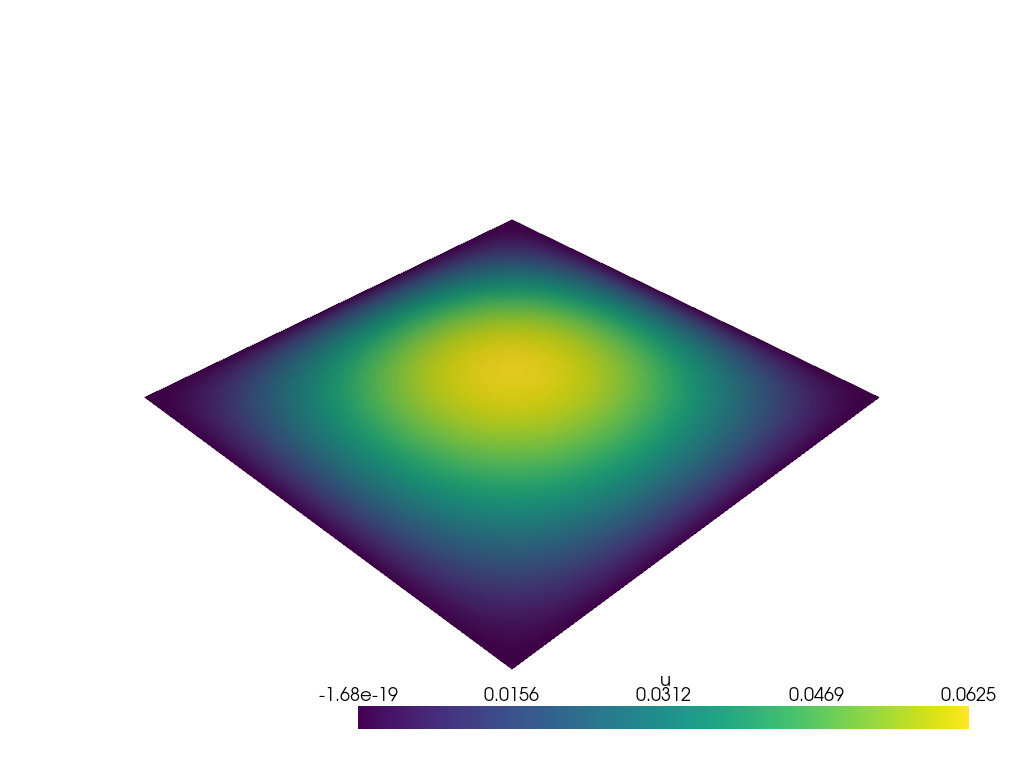

In [42]:
_uh = z

try:
    pyvista.start_xvfb()
except OSError:
    pass

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()

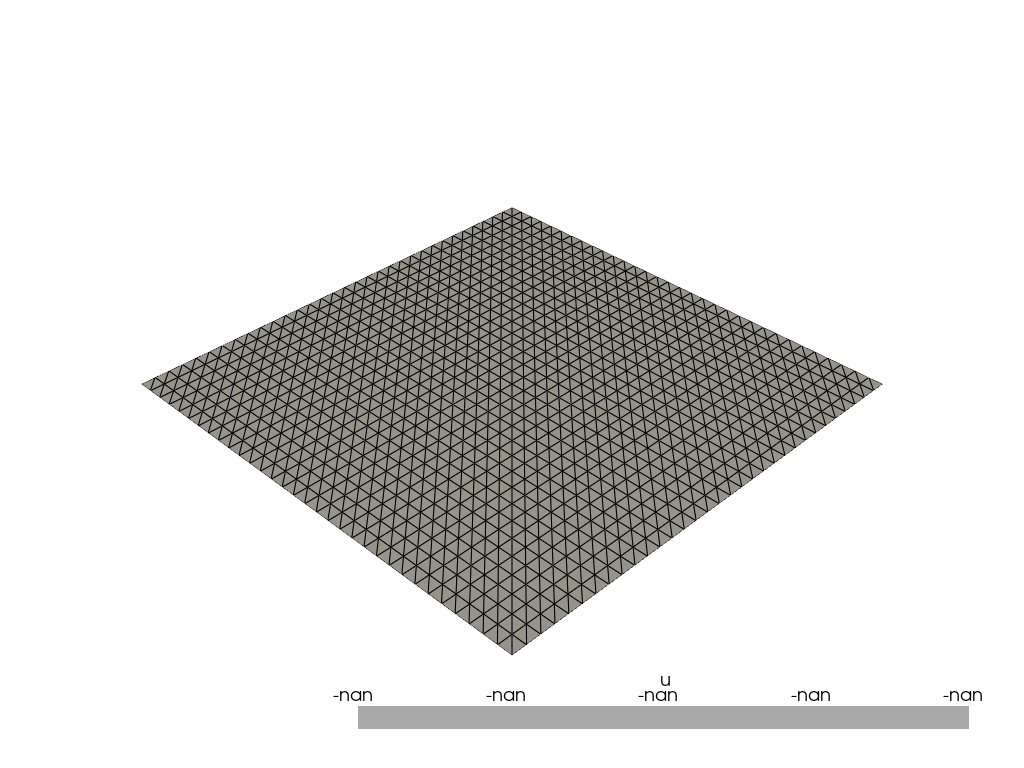

In [43]:
_uh = uh.sub(1).collapse()

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()


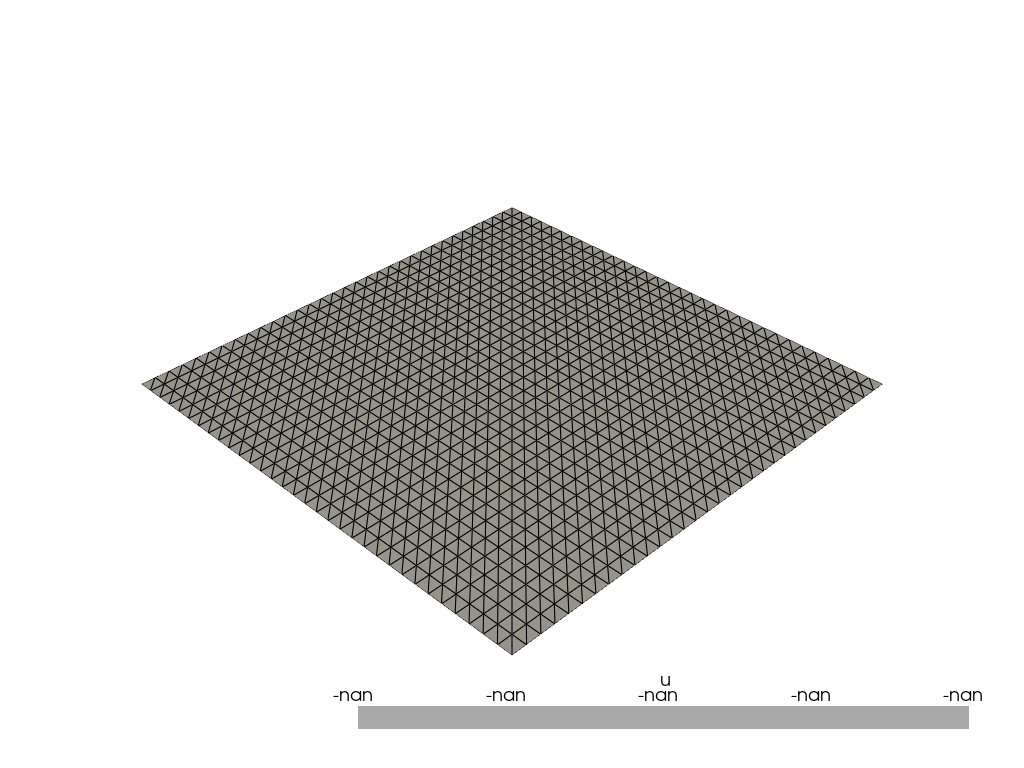

In [37]:
_uh = uh.sub(2).collapse()

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
# warped = grid.warp_by_scalar()
# plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()
